# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Exploring PINN-implementations and their performance
This notebook is the main one for my project. In it, I go through two different PINN-implementations, one following the approach from ([Ch.15, FYS-STK3155/4155](https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter11.html)), and one following the approach from ([M. Raissi et.al.](https://maziarraissi.github.io/PINNs/)), and compare their performance when solving PDEs to solutions from finite difference methods (FDMs).

The equations are the unsteady wave equation and the diffusion equation, first on a one-dimensional spatial domain, and secondly in two spatial dimensions. 

The equations are, for $u = u(t,\boldsymbol{x})$:
### Diffusion equation
$$\frac{\partial u}{\partial t} - D\nabla^{2}u = f(t,\boldsymbol{x}) $$
with $D$ as the diffusion coefficient, and $f(t,\boldsymbol{x})$ as a generic source function. 

### Wave equation
$$\frac{\partial^{2} u}{\partial t^{2}} - c^{2}\nabla^{2}u = f(t,\boldsymbol{x}) $$
with $c$ denoting the wave speed.

In the end of the notebook, I am also attempting to show one of the advantages of using PINNs to solve PDE, namely the ability to extraploate outside the initial time domain, using the trained model. 

### Notebook imports and defaults

In [1]:
from network import *
from networkFlow import *
from FiniteDiff import *
from PDEq import *
from support import *

from time import time

import autograd.numpy as anp
import numpy as np

import matplotlib.pyplot as plt

from autograd import elementwise_grad, grad

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (6,3); plt.rcParams["font.size"] = 10

2024-12-13 22:41:52.351012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 22:41:52.362581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734126112.376285  167598 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734126112.379940  167598 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 22:41:52.392249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## One-dimensional PDEs
### Problem setup

In [2]:
## Differential equations
test_cases = ['diff1d','wave1d']
test = test_cases[0]

## Coefficients
c, D, amp = 0.7, 0.1, 1.

## Setup for PINNs
if test == 'diff1d':
    PDE = Diffusion1D(sim_type='own',amp=amp,D=D)
    PDE_tf = Diffusion1D(sim_type='flow',amp=amp,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='own',amp=amp,c=c)
    PDE_tf = Wave1D(sim_type='flow',amp=amp,c=c)
    t0,tN,x0,xN = 0,1,0,1

## Domain setup
Nt,Nx = 10,10

## Defining the source function
f = PDE.right_hand_side
f_tf = PDE_tf.right_hand_side

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

domain_array = np.array([t,x])

## Setup for FD-solver
x_s,t_s = sp.symbols('x, t')
## Simulation and equation coefficients
cfl = 0.1
if test == 'diff1d':
    x_bound = [x0,xN]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amp * sp.sin(sp.pi*x_s/L)
    fd_solver = Diffusion1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,amp=amp,D=D)
    
elif test == 'wave1d':
    x_bound = [x0,xN]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amp * sp.sin(sp.pi*x_s/L)
    fd_solver = Wave1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,amp=amp,c=c)

2024-12-13 22:41:54.475331: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Network setup

In [3]:
## Layer configuration
layer_out_sizes = [20,20,20,20,1]
layer_out_sizes_tf = [20,20,1]

## Activation functions
hidden_func_tf = 'tanh' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
hidden_func = tanh
#hidden_der = elementwise_grad(hidden_func,0)
hidden_der = grad(hidden_func,0)


act_funcs_tf = []; act_funcs = []; act_ders = []
for i in range(len(layer_out_sizes)-1):
    act_funcs_tf.append(hidden_func_tf)
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)

## Output layer activation function set to identity
act_funcs_tf.append(None); 

act_funcs.append(identity); 
output_der = identity #elementwise_grad(act_funcs[-1],0);
act_ders.append(output_der)

# TensorFlow-implementation
## Gradient descent method, regularizer and learning rate
lmbda_tf = 1e-8
gd_method_tf = 'adam'
eta_tf = 5e-2 # None
tf_epoch = 2500

## Collocation tensor parameters
c_points = 2000; b_points = 20; i_points = 20

## Network initializtion
TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes_tf,
                           activation_functions=act_funcs_tf,
                           PDE=PDE_tf,
                           source_function=f_tf,
                           domain_array=domain_array,
                           domain=x_bound,
                           gd_method=gd_method_tf,
                           learning_rate=eta_tf,
                           random_state=default_seed)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
TFNetwork.create_layers(lmbda=lmbda_tf)

## Plain-implementation
## Gradient descent method, regularizer and learning rate
eta = [eta_tf if eta_tf is not None else 5e-2]
lmbda = lmbda_tf
epoch = 100
gd_method = ADAM(learning_rate=eta,lmbda=lmbda)

## Network initializtion
OwnNetwork = FFNNetwork(layer_output_size=layer_out_sizes,
                        activation_functions=act_funcs,
                        activation_derivatives=act_ders,
                        PDE=PDE,
                        source_function=f,
                        domain_array=domain_array,
                        domain=x_bound,
                        random_state=default_seed)

### Network training

In [4]:
epoch = epoch
tf_epoch = tf_epoch

own_net_timer = [time()]
#P = OwnNetwork.train_network(GDMethod=gd_method,epochs=epoch)
own_net_timer.append(time())


tf_net_timer = [time()]
TFNetwork.train_network(epochs=tf_epoch)
tf_net_timer.append(time())

print('Plain PINN-solver time     : %.2f sec.' %(own_net_timer[1]-own_net_timer[0]))
print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Final cost = 1.67492e-03
Plain PINN-solver time     : 0.00 sec.
TensorFlow PINN-solver time: 14.50 sec.


### Finite difference solver

In [ ]:
fd_timer = [time()]

fd_solver.solver(tN=t_bound[1],bc=bc)

fd_timer.append(time())

print('FD-solver time: %.2f sec.' %(fd_timer[1]-fd_timer[0]))

FD-solver time: 0.24 sec.


### Comparison between methods

Autograd solution:
Mean difference, Own: 0.16744
Max difference: 0.51632
Min difference: 0.00000
Global l² error: 0.20047

TensorFlow solution:
Mean difference, TF: 0.21575
Max difference: 0.58605
Min difference: 0.00202
Global l² error: 0.23711

Finite difference solution
Mean difference, FD: 0.01647
Max difference: 0.04810
Min difference: 0.00000
Global l² error: 0.02028



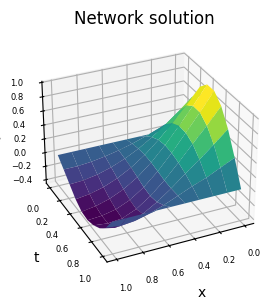

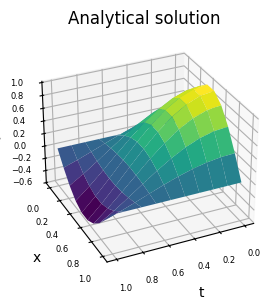

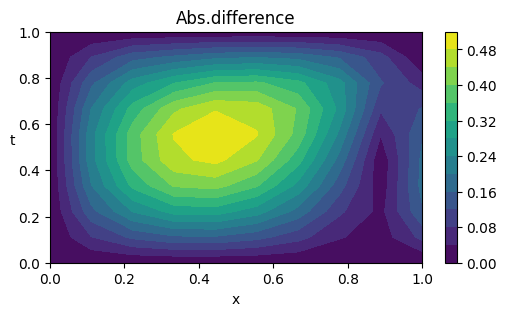

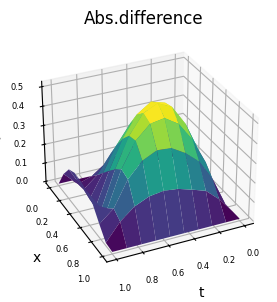

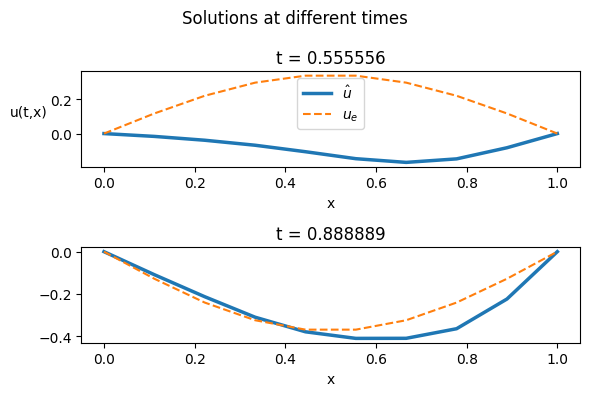

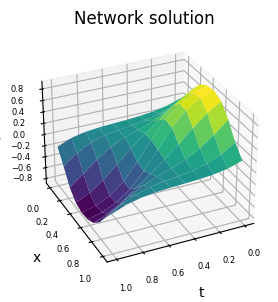

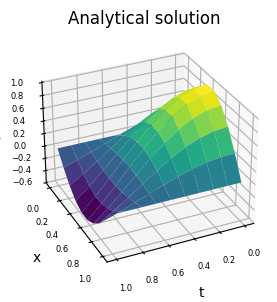

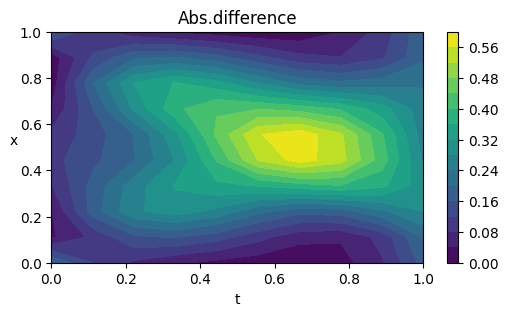

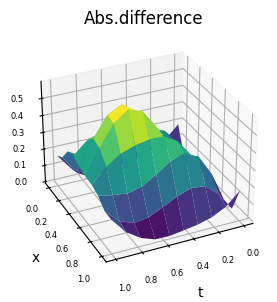

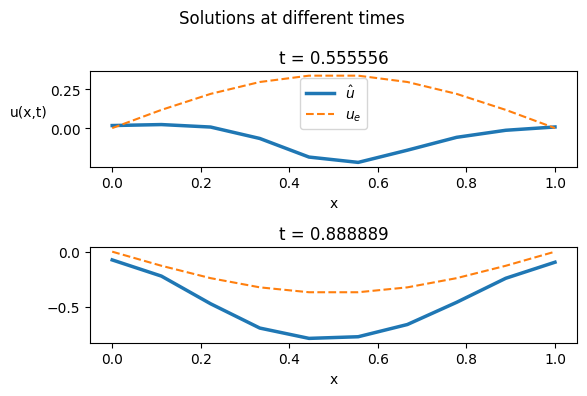

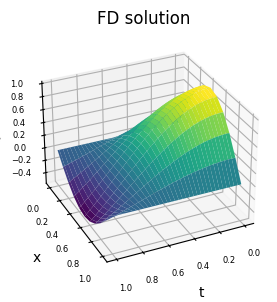

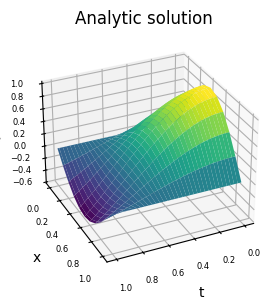

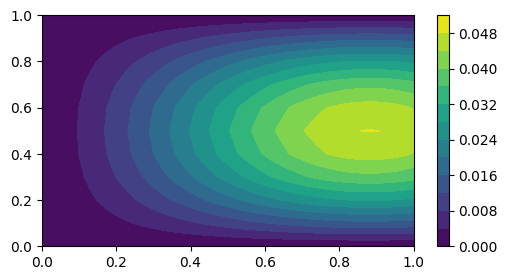

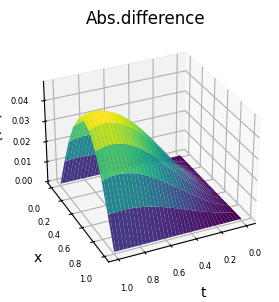

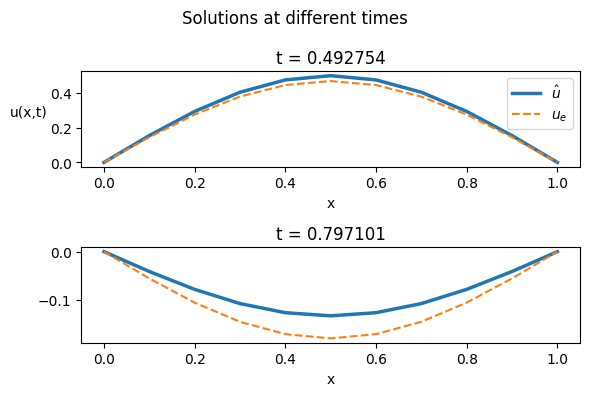

In [6]:
times = [0.5,0.8]; plots = 'all'#'solution'
#plots = 'exact'
#plots = 'solution'
OwnNetwork.plot_result(plots=plots,time=times)#,save=True,f_name=['sol_plain.png','exact.png','diff_plain_c.png','diff_plain.png'])
TFNetwork.plot_results(plots=plots,time=times)#,save=True,f_name=['sol_tf_png','exact.png','diff_tf_c.png','diff_tf.png'])
fd_solver.plot_result(tN=tN,plots=plots,time=times)#,save=True,f_name=['sol_fd.png','exact.png','diff_fd_c.png','diff_fd.png'])

print('Autograd solution:')
print('Mean difference, Own: %.5f' %OwnNetwork.abs_diff.mean())
print('Max difference: %.5f' %OwnNetwork.abs_diff.max())
print('Min difference: %.5f' %OwnNetwork.abs_diff.min())
print('Global l² error: %.5f\n' %OwnNetwork.l2_error.mean())
print('TensorFlow solution:')
print('Mean difference, TF: %.5f' %TFNetwork.abs_diff.mean())
print('Max difference: %.5f' %TFNetwork.abs_diff.max())
print('Min difference: %.5f' %TFNetwork.abs_diff.min())
print('Global l² error: %.5f\n' %TFNetwork.l2_error.mean())
print('Finite difference solution')
print('Mean difference, FD: %.5f' %fd_solver.abs_diff.mean())
print('Max difference: %.5f' %fd_solver.abs_diff.max())
print('Min difference: %.5f' %fd_solver.abs_diff.min())
print('Global l² error: %.5f\n' %fd_solver.l2_error.mean())


## Two-dimensional PDEs
### Problem setup

In [27]:
## Differential equations
test_cases = ['wave2d','diff2d']
test = test_cases[0]

## Coefficients
c,D,amp = 0.7,0.1,0.1
## Domain setup
Nt,Nx,Ny = 100,100,100

## Setup for PINN
if test == 'wave2d':
    m = [2,2]           # Integer denoting the number of standing waves in x- and y-direction 
    PDE = Wave2D(sim_type='flow',amp=amp,c=c,m=m)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amp,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

t_bound = [t0,tN]
x_bound = [x0,xN]
y_bound = [y0,yN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)
y = np.linspace(y_bound[0],y_bound[1],Ny)

domain_array = np.array([t,x,y])

## Setup for FD-solver
## Simulation and equation coefficients
cfl = 0.1
if test == 'wave2d':
    bc = {'x0': 0, 'xN': 0, 'y0': 0, 'yN': 0}
    fd_solver = Wave2DSolver(N=Nx,domain=(x_bound,y_bound),cfl=cfl,
                             amp=amp,c=c,m=m)
elif test == 'diff2d':
    bc = {'x0': 0, 'xN': 0, 'y0': 0, 'yN': 0}
    N = 20; cfl = 1.
    fd_solver = Diffusion2DSolver(N=N,domain=(x_bound,y_bound),cfl=cfl,
                                  amp=amp,D=D)
    
## Defining the source function
f = PDE.right_hand_side

### Network setup

In [28]:
## Layer configuration
l_size = 20
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
#layer_out_sizes = [l_size,l_size,l_size,l_size,1]
layer_out_sizes = [l_size,l_size,l_size,1]


## Activation functions
hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 2545
eta = 4e-2
lmbda = 2e-8 #[5e-9,2e-9]

## Collocation tensor parameters
c_points = 5000; b_points = 20; i_points = 20

TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           regularizer='l2',
                           learning_rate=eta)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)

TFNetwork.create_layers(lmbda=lmbda)

### Network training

In [29]:
tf_net_timer = [time()]

TFNetwork.train_network(epochs=epoch,tol=1e-10)

tf_net_timer.append(time())

Final cost = 3.44272e-05


### Finite differences solver

In [30]:
fd_timer = [time()]

fd_solver.solver(tN=tN,bc=bc)

fd_timer.append(time())

### Comparison

TensorFlow solution:
Mean difference, TF: 0.04300
Max difference: 0.16415
Min difference: 0.00000
Global l²-error: 0.51494

Finite difference solution
Mean difference, FD: 0.00035
Max difference: 0.00165
Min difference: 0.00000
Global l²-error: 0.00045



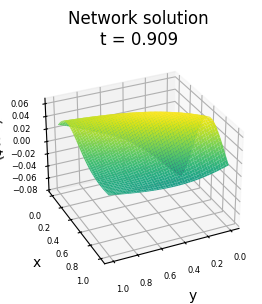

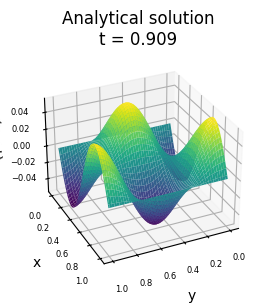

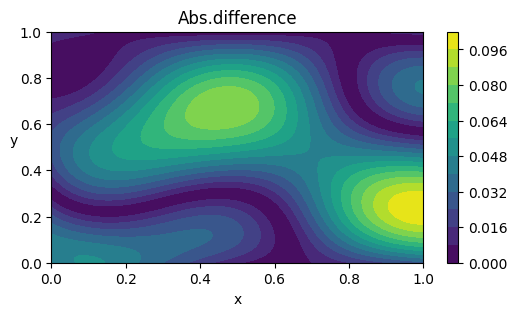

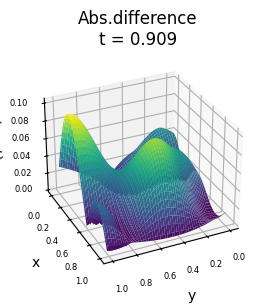

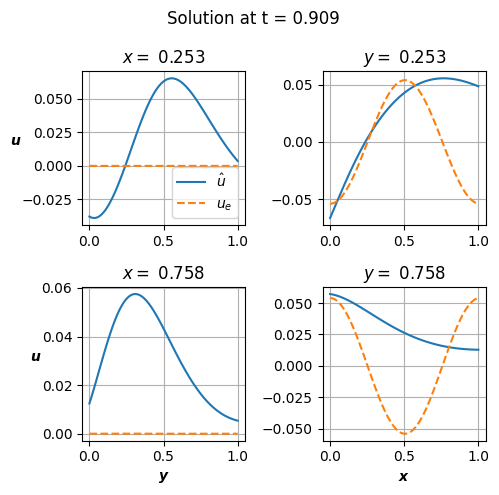

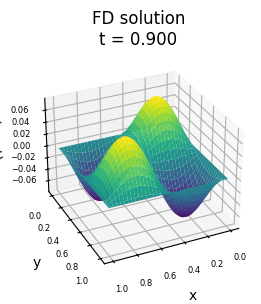

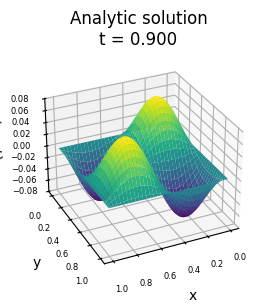

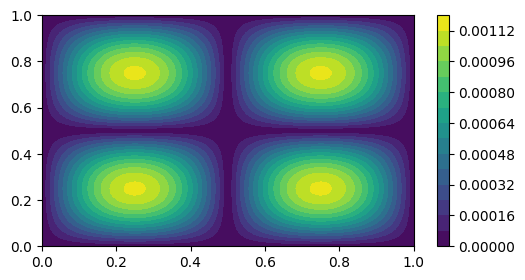

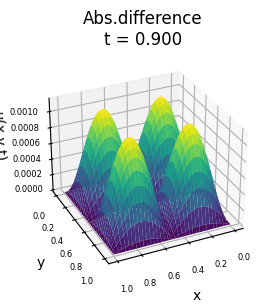

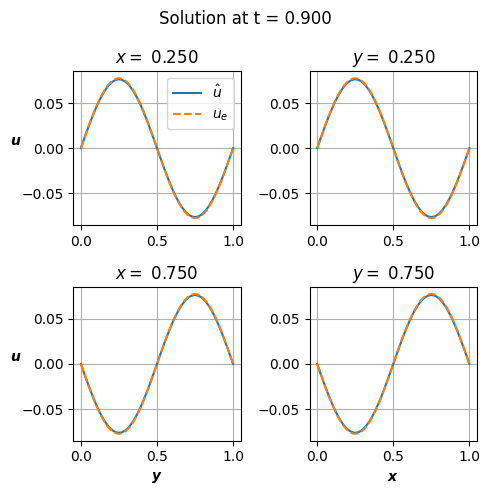

In [31]:
times = [0.9]; spaces=([0.25,0.75],[0.25,0.75]); plots = 'all'#; plots = 'exact'
TFNetwork.plot_results(plots=plots,time=times,space=spaces)#,save=True,f_name=['sol_tf_2d.png','exact_2d.png','diff_tf_c_2d.png','diff_tf_2d.png'])
fd_solver.plot_result(plots=plots,time=times,space=spaces)#,save=True,f_name=['sol_fd_2d.png','exact_2d.png','diff_fd_c_2d.png','diff_fd_2d.png'])
#,save=True,f_name=['sol_tf_png','exact.png','diff_tf_c.png','diff_tf.png'])
#,save=True,f_name=['sol_fd.png','exact.png','diff_fd_c.png','diff_fd.png'])

print('TensorFlow solution:')
print('Mean difference, TF: %.5f' %TFNetwork.abs_diff.mean())
print('Max difference: %.5f' %TFNetwork.abs_diff.max())
print('Min difference: %.5f' %TFNetwork.abs_diff.min())
print('Global l²-error: %.5f\n' %TFNetwork.l2_error.mean())
print('Finite difference solution')
print('Mean difference, FD: %.5f' %fd_solver.abs_diff.mean())
print('Max difference: %.5f' %fd_solver.abs_diff.max())
print('Min difference: %.5f' %fd_solver.abs_diff.min())
print('Global l²-error: %.5f\n' %fd_solver.l2_error.mean())

## Reusing trained network
### Network setup

In [32]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
layer_out_sizes = [20,20,1]

## Activation functions
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 2500
eta = 5e-2
lmbda = 1e-8

## Collocation tensor parameters
c_points = 5000; b_points = 20; i_points = 20

TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)

TFNetwork.create_layers(lmbda=lmbda)

### Network training

In [ ]:
tf_net_timer = [time()]

TFNetwork.train_network(epochs=epoch)

tf_net_timer.append(time())

In [ ]:
TFNetwork.plot_results(plots='all',time=[0.5])

### New domain

In [22]:
## New time domain
tMax = 2.5
t_bound = [0,tMax]
t = np.linspace(t_bound[0],t_bound[1],Nt)
#domain_array = np.array([t,x,y])
domain_array = np.array([t,x])


#tt,xx,yy = np.meshgrid(t,x,y,indexing='ij')
tt,xx = np.meshgrid(t,x,indexing='ij')
#xgrid = np.vstack((tt.flatten(),xx.flatten(),yy.flatten())).T
xgrid = np.vstack([tt.flatten(),xx.flatten()]).T


### Prediction of extrapolated domain

(10, 10)
(10, 10)


(<Figure size 450x375 with 1 Axes>,
 <Axes3D: title={'center': 'Extraploated to t = 3'}, xlabel='x', ylabel='t', zlabel='u'>)

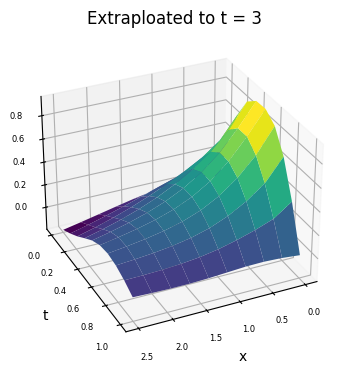

In [26]:
newsol = TFNetwork.model(tf.cast(xgrid,tf.float32))
sol = newsol.numpy().reshape(tt.shape)
t_idx = 5
print(tt.shape)
print(sol.shape)
#plot2D(xx[t_idx,:,:],yy[t_idx,:,:],sol[t_idx,:,:])
plot2D(tt,xx,sol,labels=['Extraploated to t = 3','x','t','u'],save=True,f_name='extrapol.png')